# [2023-11-07] Principal factors of variation

For a given data tensor of counts $\mathbf{X} \in \mathbb{N}^{D_1, D_2, D_3}$, 
the Dirichlet Tucker Decomposition model fits a set of $(K_1, K_2, K_3)$ factors
to the respective modes.

While each factor contributes to a model's a goodness-of-fit to the data,
some factors may contribute more significantly to the model fit to the data.

In a method such as principal component analysis (PCA), fitted components can be
ordered by amount of data variation explained. This is directly achieved by sorting
components (which are right eigenvectors of a singular value decomposition), by
the magnitude of their corresponding eigenvalue -- components with larger eigenvalues
explain a greater portion of variance of the data. In probabilistic PCA, this 
directly correlates with the components that explain a greater log likelihood
**(!! need to fact check this !!)**.

DTD does not explicitly find any scalar value that can be used to sort its fitted
factors within each mode. However, we can take the principle of sorting factors
by their contribution to log-likelihood.

We perform this analysis by holding one factor out and evaluating log likelihood
with the remaining factors. The log likelihood resulting from holding out the
$k$-th factor of mode 1 is given by
$$
\ell_{\setminus k} = \left[\mathcal{G}_{\setminus k,:,:}; F_{1\setminus k}, F_2, F_3 \right].
$$
Let $\ell_j$ be the log likelihood resulting from holding out the $j$-th factor,
where $k \neq j$. Then, if $\ell_k < \ell_j$, we would conclude that the $k$-th factor
is more significant than the $j$-th factor because the model's performance
decreased _without_ its inclusion.

While the above can be considered a "destructive" evaluation approach, we could have
alternatively chosen a "constructive" approach where we evalute each factor
independently,
$$
\ell_k = \left[\mathcal{G}_{k,:,:}; F_{1, k}, F_2, F_3 \right].
$$
While these the destructive and construtive approaches are equivalent in a method
with orthogonal factors, such as PCA or Tucker decomposition with orthogonality constraints,
the approaches are _not_ equivalent when the factors are non-orthogonal, as in DTD.
**(!! should expand on this !!)**.

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as onp
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from dtd.utils import download_wnb_params
from kf_viz import draw_syllable_factors, draw_circadian_bases
sns.set_style("darkgrid")

In [3]:
wnb_entity = 'eyz'
wnb_project = 'kf-dtd-231022'

# List run_ids to compare in this notebook
run_ids = [
    'ig6dh2fo',     # `warm-sweep-116`, seed = 1698740237
    '46grddu7',     # `eternal-sweep-28`, seed = 1698499854
    ]

# (Down)load fitted run parameters 
run_params = {
    run_id: download_wnb_params(wnb_entity, wnb_project, run_id)
    for run_id in run_ids
}

# Single run examination

In [24]:
# For loop implementation
leave_one_out = dict(
ll_1 = onp.array(
    [-1.7537652e+09, -1.7297821e+09, -1.8529139e+09, -1.7050954e+09,
     -1.7069111e+09, -1.7827174e+09, -1.6903112e+09, -1.7885407e+09,
     -1.6667978e+09, -1.7442405e+09, -1.6799776e+09, -1.7377999e+09,
     -1.7515832e+09, -1.7687345e+09, -1.6820951e+09, -1.7374433e+09,
     -1.7782109e+09, -1.8318404e+09, -1.7262614e+09, -1.7128576e+09,
     -1.7684429e+09, -1.7680420e+09, -1.7928415e+09, -1.8131963e+09,
     -1.7468570e+09, -1.6662085e+09, -1.6805407e+09, -1.7550546e+09,
     -1.7461563e+09, -1.6684175e+09, -1.6912829e+09, -1.7358223e+09,
     -1.7649285e+09, -1.7567180e+09, -1.7423453e+09, -1.9282627e+09,
     -1.7432870e+09, -1.8394135e+09, -1.7156484e+09, -1.7084462e+09,
     -1.7871058e+09, -1.6838019e+09, -1.7079049e+09, -1.7575168e+09,
     -1.7656983e+09, -1.7470945e+09, -1.7159031e+09, -1.7306506e+09,
     -1.7289905e+09, -1.7513190e+09,]
),
ll_2 = onp.array(
    [-2.5495217e+09, -2.4881725e+09, -2.1595662e+10, -1.0109768e+10,]
),
ll_3 = onp.array(
    [-1.8114092e+09, -1.7115036e+09, -1.8115242e+09, -1.7963295e+09,
     -1.8169121e+09, -1.7747494e+09, -1.8563132e+09, -3.1589430e+09,
     -1.8668319e+09, -1.7606072e+09, -3.6712415e+09, -3.3338332e+09,
     -1.7203116e+09, -1.7285549e+09, -1.8322732e+09, -1.8520554e+09,
     -1.7075622e+09, -3.1688064e+09, -1.8218572e+09, -6.4150815e+09,
     -1.7256721e+09, -1.9038003e+09, -2.2038374e+09, -1.7277478e+09,
     -6.0223375e+09, -2.1011812e+09, -1.8685338e+09, -1.8320192e+09,
     -1.6999386e+09, -1.9555524e+09,]
)
)

ref_ll_dict = dict(
    test = -1606212400.,
    baseline = -3941965000.,
    saturated = -88931120.
)

Now, given the held-out log likelihoods, we sort the factors from lowest to highest log likelihood.
The lower the "leave-one-out" log likelihood, the more that that factor contributed to the goodness-of-fit.
We evaluate the LOFO held-out log likelihood, $\ell_{\setminus k}$, as well as compute the fraction difference from the reference,
all-factors-included held-out log likleihood, $\ell_\textrm{ref}$,
$$
\textrm{frac diff} = \frac{\ell_{\textrm{ref} - \ell_{\setminus k}}}{\ell_\textrm{ref}}
$$

These results are a bit surprising...I would have expected that the distributions be (qualitatively) similar between
using a single factor vs. leaving one factor out. Where might this discrepancy come from?
- Using a model with just a single factor in one of the modes is so detrimental that we lose any meaninful modelling
  - We also have much better "SNR" of principle factors from the less principle factors (see the big gaps)
- Could this be a numerical thing? We expected our probabilities to sum to one -- but this is violated in both cases (especially in leave one in)
    - **UPDATE** Confirmed, probs don't sum to one, but normalizing them (in the leave one factor in case) did not affect the heldout lls at all. This could be that even though TFD expects probs to sum to 1, it converts it into logits under the hood so that it doesn't actually matter (and us normalize does not matter)
    - This gives more weight to the first hypothesis that just keeping one factor in is very detrimental to the odel.

## Leave one out SCAN ... WITH probs normalization

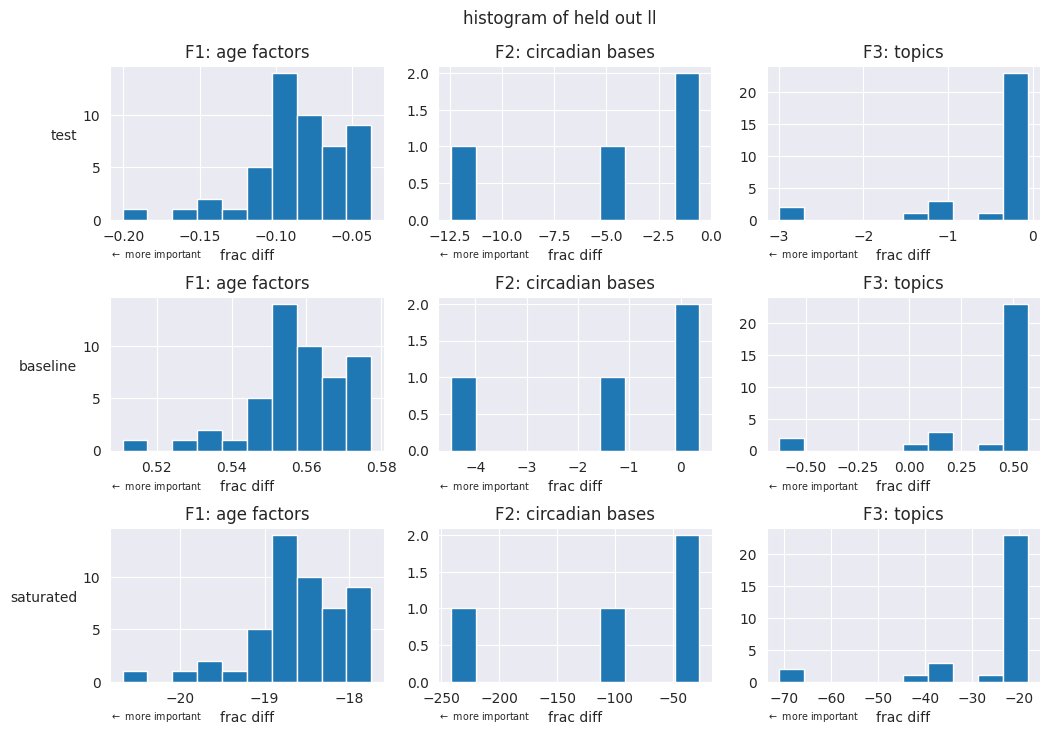

In [27]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,8),
                        gridspec_kw={'hspace': 0.5})

for i, title in enumerate(['age factors', 'circadian bases', 'topics']):
    # Leave one out
    ll = leave_one_out[f'll_{i+1}']

    for ii, (ref_key, ref_ll) in enumerate(ref_ll_dict.items()):
        frac_diff = (ref_ll - ll) / ref_ll

        ax = axs[ii,i]
        ax.hist(frac_diff)
        ax.set_title(f'F{i+1}: {title}')
        ax.set_xlabel('frac diff')
        # ax.set_xlim(right=0)

        if i == 0:
            ax.set_ylabel(ref_key, ha='right', rotation=0)

        ax.annotate(r'$\leftarrow$ more important', (0,-0.25), xycoords='axes fraction', ha='left', fontsize='x-small')

fig.suptitle(f'histogram of held out ll', y=0.95)
fig.tight_layout()

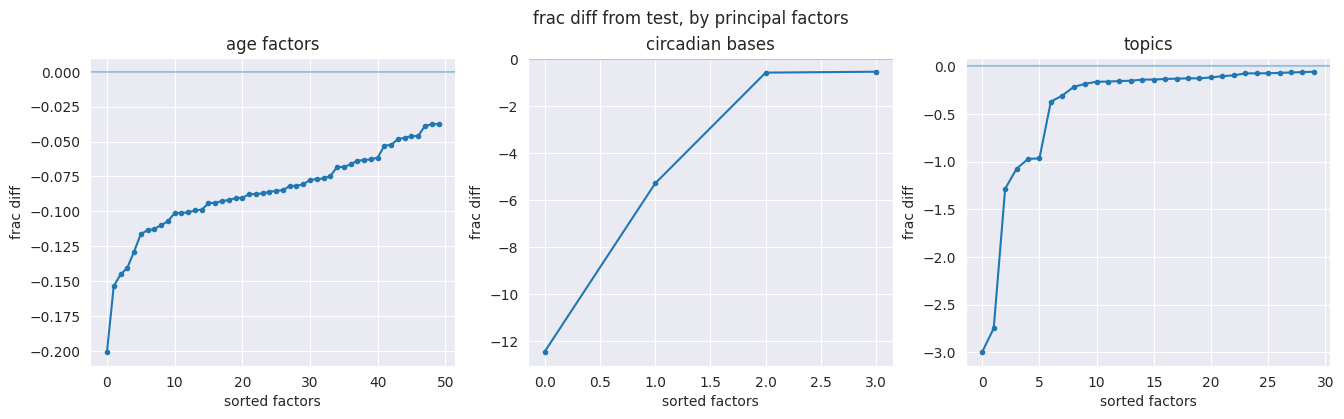

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=3,
                        figsize=(16,4), gridspec_kw={'hspace': 0.5})

ref_key = 'test'
ref_ll = ref_ll_dict[ref_key]
for i, title in enumerate(['age factors', 'circadian bases', 'topics']):
    # Leave one out
    ll = leave_one_out[f'll_{i+1}']
    ll_sorted = onp.sort(ll)

    frac_diff = (ref_ll - ll_sorted) / ref_ll 

    ax = axs[i]
    ax.plot(frac_diff, marker='.')
    
    ax.set_xlabel('sorted factors')

    ax.set_ylabel('frac diff')
    ax.set_title(title)

    ax.axhline(0, alpha=0.4,)

# for ii, ylabel in enumerate(['test ll', 'baseline ll', 'saturated ll']):
#     axs[ii,0].set_ylabel(ylabel, ha='right', rotation=0)

fig.suptitle(f'frac diff from {ref_key}, by principal factors', y=1.)
fig.tight_layout()

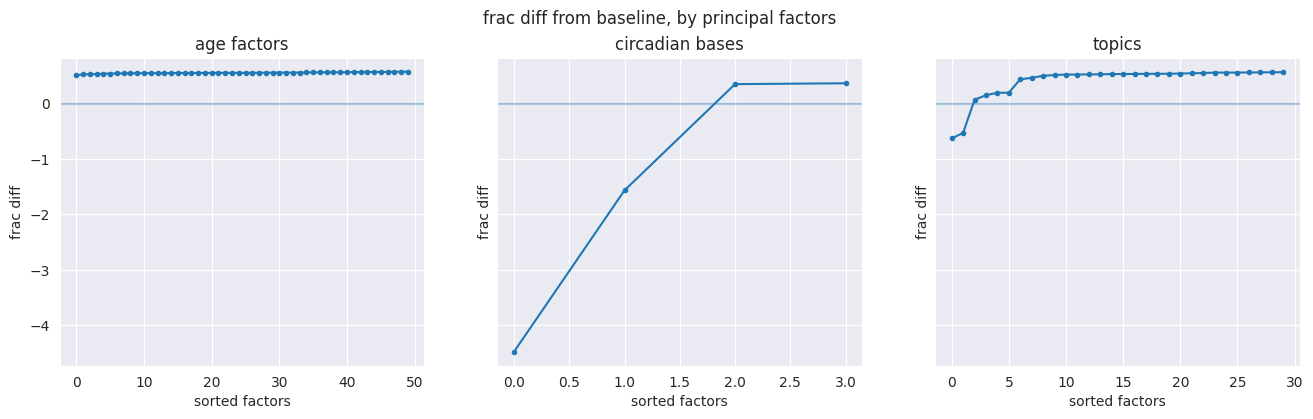

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True,
                        figsize=(16,4), gridspec_kw={'hspace': 0.5})

ref_key = 'baseline'
ref_ll = ref_ll_dict[ref_key]
for i, title in enumerate(['age factors', 'circadian bases', 'topics']):
    # Leave one out
    ll = leave_one_out[f'll_{i+1}']
    ll_sorted = onp.sort(ll)

    frac_diff = (ref_ll - ll_sorted) / ref_ll 

    ax = axs[i]
    ax.plot(frac_diff, marker='.')
    
    ax.set_xlabel('sorted factors')

    ax.set_ylabel('frac diff')
    ax.set_title(title)

    
    ax.axhline(0, alpha=0.4,)


# for ii, ylabel in enumerate(['test ll', 'baseline ll', 'saturated ll']):
#     axs[ii,0].set_ylabel(ylabel, ha='right', rotation=0)

fig.suptitle(f'frac diff from {ref_key}, by principal factors', y=1.)
fig.tight_layout()

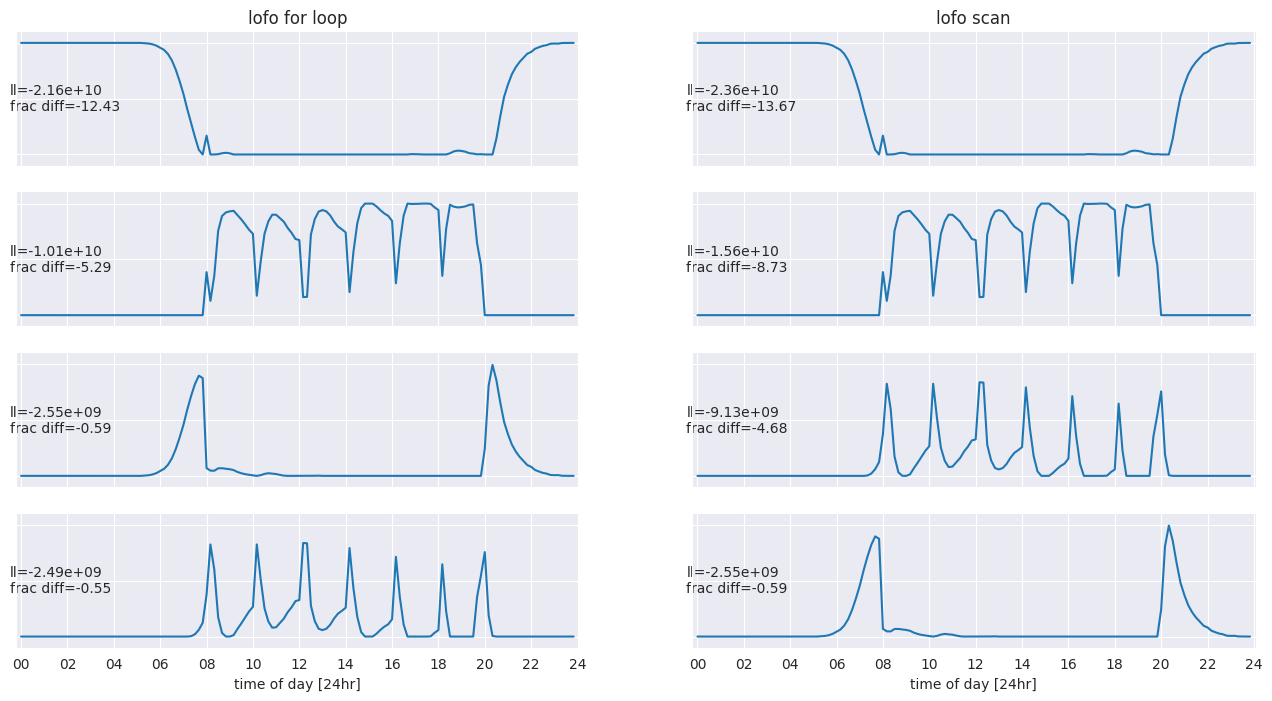

In [46]:
fig = plt.figure(figsize=(16,8))

gs_outer = GridSpec(nrows=1, ncols=2)

G, F1, F2, F3 = params
D2, K2 = F2.shape

for i, (results_dict, title) in enumerate(
    zip([leave_one_out, leave_one_out_with_scan], ['lofo for loop', 'lofo scan'])):

    ll = results_dict['ll_2']
    frac_diff = (ref_ll - ll) / ref_ll
    idxs_sorted = onp.argsort(ll)
    
    # Draw factors
    gs_inner = gs_outer[:,i].subgridspec(K2, 1)
    axs = [fig.add_subplot(gs_inner[i_k]) for i_k in range(K2)]
    draw_circadian_bases((G, F1, F2[:,idxs_sorted], F3), autosort=False, axs=axs)

    # Label factors with ll and frac diff
    for ax, idx in zip(axs, idxs_sorted):
        ax.set_ylabel(f'll={ll[idx]:.2e}\nfrac diff={frac_diff[idx]:.2f}', rotation=0, ha='left', va='center',)

    axs[0].set_title(title)

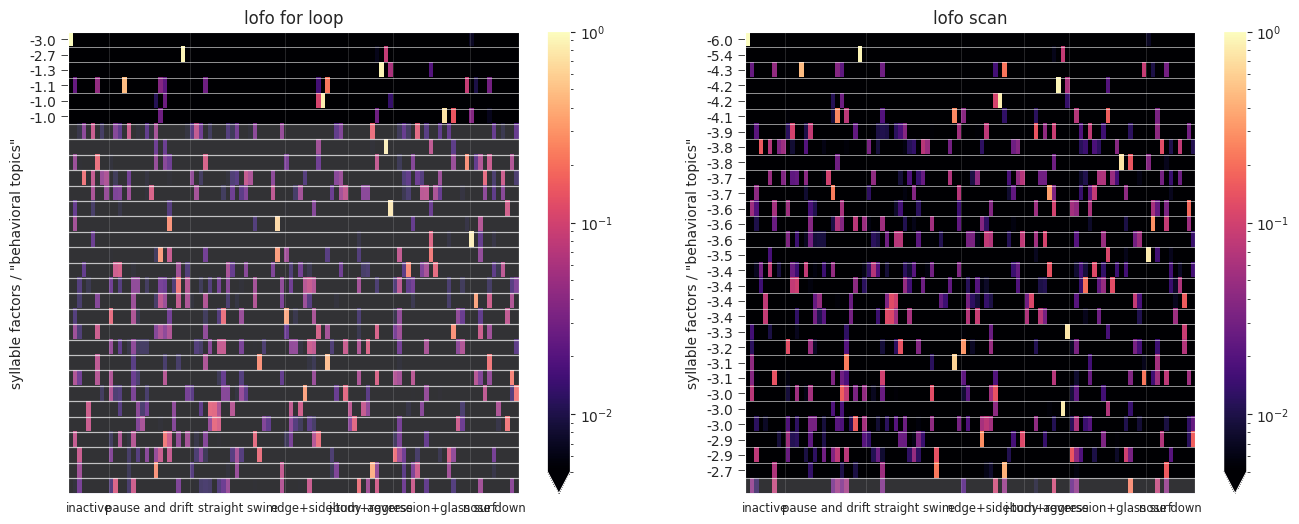

In [43]:
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(16,6))

gs_outer = GridSpec(nrows=1, ncols=2)

G, F1, F2, F3 = params
K3, D3 = F3.shape

for i, (results_dict, title, thresh) in enumerate(
    zip([leave_one_out, leave_one_out_with_scan], ['lofo for loop', 'lofo scan'],[-0.75, -2])):

    ll = results_dict['ll_3']
    idxs_sorted = onp.argsort(ll)
    ll = ll[idxs_sorted]
    frac_diff = (ref_ll - ll) / ref_ll

    ax = fig.add_subplot(gs_outer[:,i])
    draw_syllable_factors((G, F1, F2, F3[idxs_sorted,:]), autosort=False, ax=ax)

    # If a factor is not within threshold, "dim" it with transparent white mask
    mask = (frac_diff <= thresh)
    for i in onp.nonzero(~mask)[0]:
        rect = Rectangle((-0.5,i-0.5,), 100, 1, facecolor='w', alpha=0.2)
        ax.add_patch(rect)
    
    # Set minor ticks, so as not to affect gridding
    # ax.yaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
    ax.set_yticks(onp.nonzero(mask)[0], minor=True)
    ax.set_yticklabels([f'{f:.1f}' for f in frac_diff[mask]], minor=True)
    ax.tick_params(axis='y', which='minor', left=True, length=5)

    ax.set_title(title)

## Compare across two different fits

In [47]:
leave_one_out_with_scan_2 = dict(
ll_1 = onp.array(
[-1.8053051e+09, -1.8096891e+09, -1.7412531e+09, -1.8195059e+09,
 -1.6737148e+09, -1.7226524e+09, -1.8293139e+09, -1.7193843e+09,
 -1.8417321e+09, -1.7167425e+09, -1.6892713e+09, -1.8510647e+09,
 -1.7540708e+09, -1.7498604e+09, -1.8301202e+09, -1.7490692e+09,
 -1.7078180e+09, -1.7838305e+09, -1.7764274e+09, -1.7681139e+09,
 -1.7181583e+09, -1.7399468e+09, -1.7255104e+09, -1.6822484e+09,
 -1.7168108e+09, -1.7430856e+09, -1.7295488e+09, -1.8149466e+09,
 -1.8306171e+09, -1.8154036e+09, -1.6830931e+09, -1.7269617e+09,
 -1.9333251e+09, -1.6766633e+09, -1.8161336e+09, -1.7444182e+09,
 -1.7217871e+09, -1.7376676e+09, -1.9739663e+09, -1.7159693e+09,
 -1.7897827e+09, -1.7647693e+09, -1.7812524e+09, -1.7759823e+09,
 -1.7243485e+09, -1.7635722e+09, -1.7113820e+09, -1.7285468e+09,
 -1.8010669e+09, -1.6923438e+09]
),
ll_2 = onp.array(
    [-2.0603379e+09, -1.0091448e+10, -2.0966042e+10, -1.9595438e+10]
),
ll_3 = onp.array(
[-4.7539794e+09, -7.0842214e+09, -7.3390843e+09, -8.3336755e+09,
 -8.8686674e+09, -7.2702505e+09, -7.8465311e+09, -7.1209574e+09,
 -7.3560351e+09, -7.4823255e+09, -7.6349921e+09, -7.8649149e+09,
 -7.0135209e+09, -6.9378806e+09, -6.5647432e+09, -6.5252572e+09,
 -1.0941567e+10, -7.0211630e+09, -8.0330429e+09, -7.1809213e+09,
 -8.2590587e+09, -6.8740526e+09, -6.9629348e+09, -7.5389870e+09,
 -7.8497659e+09, -7.2520919e+09, -7.4598697e+09, -7.3676529e+09,
 -6.6490860e+09, -6.8557865e+09]
)
)

Text(0.5, 1.1, 'histogram of held out ll  |  run_id: ig6dh2fo, rank=(50, 4, 30)')

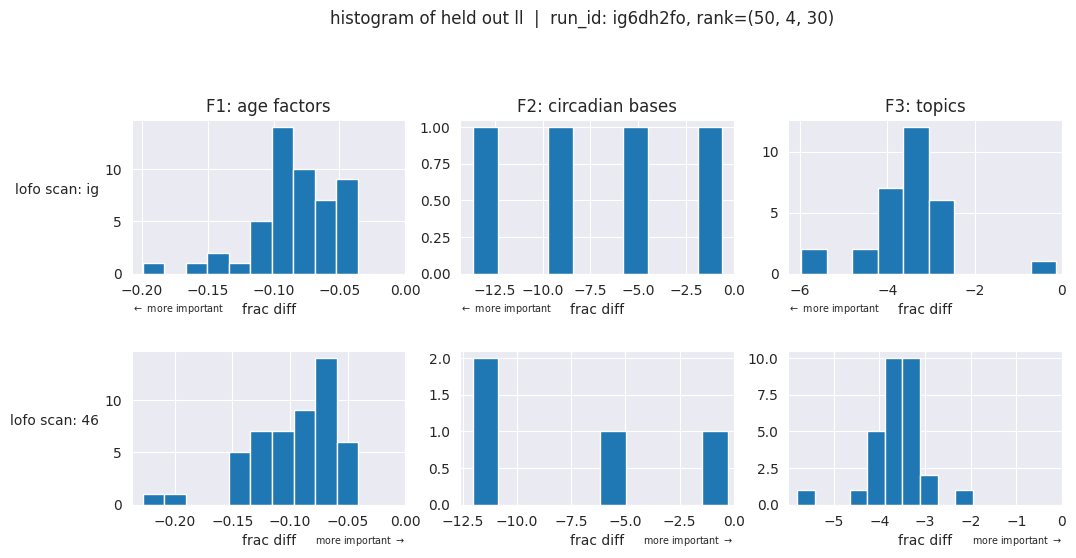

In [53]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,5),
                        gridspec_kw={'hspace': 0.5})

for i, title in enumerate(['age factors', 'circadian bases', 'topics']):
    # Leave one out
    ll = leave_one_out_with_scan[f'll_{i+1}']
    frac_diff = (ref_ll - ll) / ref_ll

    ax = axs[0,i]
    ax.hist(frac_diff)
    ax.set_title(f'F{i+1}: {title}')
    ax.set_xlabel('frac diff')
    ax.set_xlim(right=0)
    ax.annotate(r'$\leftarrow$ more important', (0,-0.25), xycoords='axes fraction', ha='left', fontsize='x-small')

    # Leave one in
    ll = leave_one_out_with_scan_2[f'll_{i+1}']
    frac_diff = (ref_ll - ll) / ref_ll

    ax= axs[1,i]
    ax.hist(frac_diff)
    # ax.set_title(f'F{i+1}: {title}')
    ax.set_xlabel('frac diff')
    ax.set_xlim(right=0)
    ax.annotate(r'more important $\rightarrow$', (1, -0.25), xycoords='axes fraction', ha='right', fontsize='x-small')

axs[0,0].set_ylabel('lofo scan: ig', ha='right', rotation=0)
axs[1,0].set_ylabel('lofo scan: 46', ha='right', rotation=0)
fig.suptitle(f'histogram of held out ll  |  run_id: {run_id}, rank={G.shape}', y=1.1)

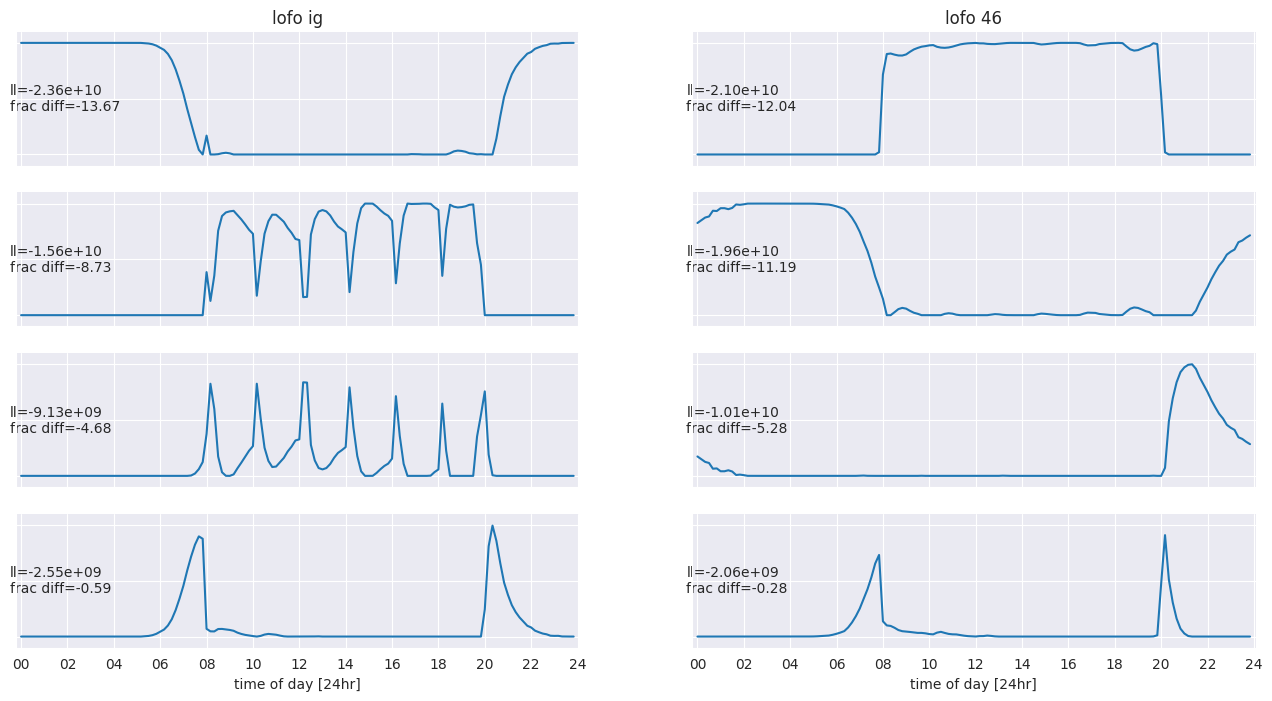

In [52]:
fig = plt.figure(figsize=(16,8))

gs_outer = GridSpec(nrows=1, ncols=2)

for i, (results_dict, title, _params) in enumerate(
    zip([leave_one_out_with_scan, leave_one_out_with_scan_2], ['lofo ig', 'lofo 46'], (params, params_2))):

    G, F1, F2, F3 = _params
    D2, K2 = F2.shape

    ll = results_dict['ll_2']
    frac_diff = (ref_ll - ll) / ref_ll
    idxs_sorted = onp.argsort(ll)
    
    # Draw factors
    gs_inner = gs_outer[:,i].subgridspec(K2, 1)
    axs = [fig.add_subplot(gs_inner[i_k]) for i_k in range(K2)]
    draw_circadian_bases((G, F1, F2[:,idxs_sorted], F3), autosort=False, axs=axs)

    # Label factors with ll and frac diff
    for ax, idx in zip(axs, idxs_sorted):
        ax.set_ylabel(f'll={ll[idx]:.2e}\nfrac diff={frac_diff[idx]:.2f}', rotation=0, ha='left', va='center',)

    axs[0].set_title(title)

# EXTRA -- to delete

In [ ]:
# Lofi results...so muchfaster!!

# copied from accompanying lofi.npz file
leave_one_in = dict(
ll_1 = onp.array(
    [-7.1453401e+10, -7.8399398e+10, -6.3677596e+10, -5.7371156e+10,
     -7.7572055e+10, -7.5946918e+10, -6.1451547e+10, -6.7098247e+10,
     -7.2258945e+10, -6.6471621e+10, -9.1851112e+10, -8.0087581e+10,
     -5.5968334e+10, -7.3964241e+10, -7.4787209e+10, -7.1841972e+10,
     -5.9893744e+10, -5.7032008e+10, -6.3475847e+10, -7.4789929e+10,
     -7.0372491e+10, -6.8457054e+10, -6.2983102e+10, -8.4668891e+10,
     -6.6242634e+10, -7.3644540e+10, -7.1523287e+10, -6.8307608e+10,
     -7.2571945e+10, -8.1290412e+10, -7.8338056e+10, -6.7078459e+10,
     -6.8390085e+10, -6.0623249e+10, -7.0906683e+10, -5.6018084e+10,
     -7.0053773e+10, -6.9091033e+10, -7.1798333e+10, -8.4151697e+10,
     -7.7343908e+10, -7.0442590e+10, -6.1746233e+10, -6.9327970e+10,
     -7.2033206e+10, -7.9671411e+10, -8.2064925e+10, -6.8866662e+10,
     -6.8963918e+10, -7.3959752e+10,]
    ),
ll_2 = onp.array(
    [-6.0819980e+10, -5.5897371e+10, -4.4878266e+10, -4.5807428e+10,]
),
ll_3 = onp.array(
    [-7.2004190e+10, -7.8663238e+10, -8.5027127e+10, -9.1326128e+10,
     -7.9308030e+10, -8.3022922e+10, -8.4051100e+10, -8.2450989e+10,
     -8.3701531e+10, -7.9594873e+10, -9.5707161e+10, -8.1555800e+10,
     -7.8173487e+10, -9.4733894e+10, -8.1646338e+10, -9.0546676e+10,
     -8.3052085e+10, -8.0861176e+10, -7.9114224e+10, -9.2850684e+10,
     -9.8111513e+10, -9.2952338e+10, -7.1646929e+10, -9.7541243e+10,
     -7.6809175e+10, -8.2874450e+10, -9.4163288e+10, -9.3671277e+10,
     -8.2569380e+10, -7.5416216e+10]
)
)